In [13]:
## Notebook to analyze the anode/cathode waveforms from the liquid purity monitor and calculate
## the outgassing rate

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../WaveformAnalysis/')
import Dataset as ds
import datetime
from matplotlib.dates import DateFormatter

In [14]:
## path to data
data_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/nEXO/lifetime_analysis/data/20230804/'

## glob string for filenames to use
filename = 'LXe_C2700*.h5'

anode_ch, cath_ch = 0, 1 ## channel numbers for anode and cathode

In [15]:
## intialize the dataset object and import data
dset = ds.Dataset(data_path, Selection=filename)
channels = dset.InitializeChannels()
for filename in dset.Files:
    dset.ImportDataFromHDF5(filename, channels)

In [16]:
## get waveforms and baseline subtract
templates = []
for ii, ch in enumerate(channels):
    # print(" | Processing data in channel %d..." % (ch.ID))
    ch.GetSampling()
    ch.Amp = [x for _, x in sorted(zip(ch.TimeStamp, ch.Amp))]
    ch.Amp = np.array(ch.Amp)

    ch.FiltAmp = np.zeros_like(ch.Amp)
    ch.FiltAmp = ch.FilterWaveforms(ch.Amp,1e3, 2e5)

    ch.TimeStamp = np.array(sorted(ch.TimeStamp))

    ch.Amp = ch.SubtractBaseline(Data=ch.Amp)

    templates.append(ch.MakeTemplate(ch.Amp))

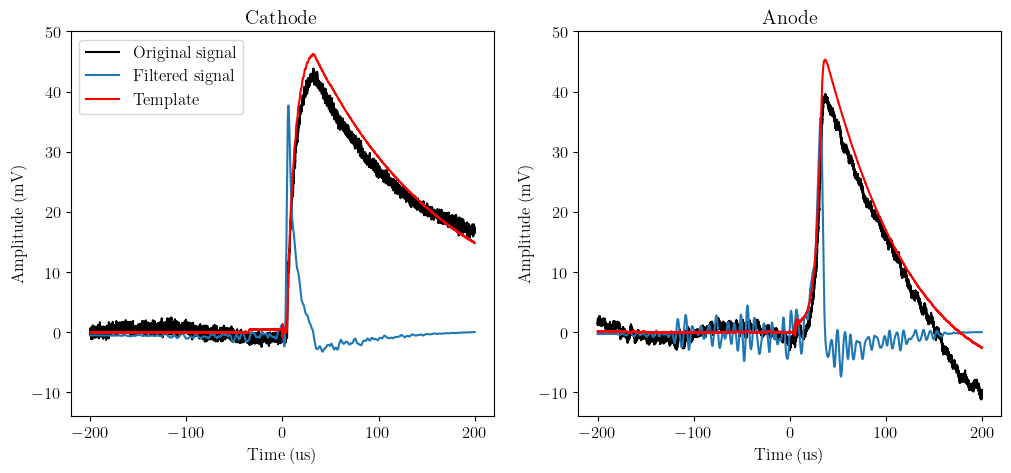

In [17]:
## make some plots to check data/filtering looks good
plt.figure(figsize=(12,5))

title_list = ['Cathode', 'Anode']

min_y_ax, max_y_ax = 0, 50
for i, chidx in enumerate([cath_ch, anode_ch]):
    ch = channels[chidx]
    plt.subplot(1,2,1+i)
    plt.plot(ch.Time, ch.Amp[0], 'k',label="Original signal")
    plt.plot(ch.Time, ch.FiltAmp[0], label="Filtered signal")
    plt.plot(ch.Time, templates[chidx], 'r', label="Template")

    plt.xlabel('Time (us)')
    plt.ylabel('Amplitude (mV)')
    plt.title(title_list[i])

    yy = plt.ylim()
    if yy[0] < min_y_ax:
        min_y_ax = yy[0]
    if yy[1] > max_y_ax:
        max_y_ax = yy[1]

## make equal autosized axes for both plots
for i, chidx in enumerate([cath_ch, anode_ch]):
    plt.subplot(1,2,1+i)
    if(i==0): plt.legend()
    plt.ylim(min_y_ax, max_y_ax)

plt.show()

In [18]:
## now reconstruct the pulse amplitudes for each waveform two ways:
## 1) fitting to the template
## 2) Max of the filtered waveform

for ii, ch in enumerate(channels):

    ch.ReconstructFitAmplitude(ch.Amp, templates[ii]) 
    ch.ReconstructFiltAmplitude(ch.FiltAmp) 

TypeError: only integer scalar arrays can be converted to a scalar index

ValueError: x and y must have same first dimension, but have shapes (970,) and (0,)

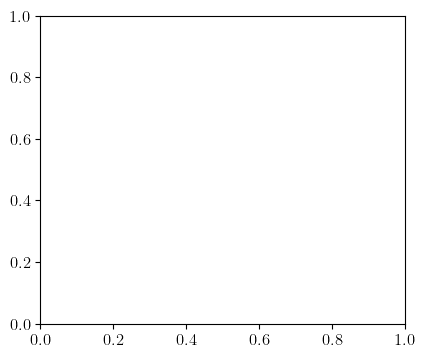

In [ ]:
## Make some plots of the reconstructed amplitudesm rebinning to 5 minute intervals

rebin = 5/60. ## rebin to 5 minute intervals

amp_methods_to_use = ['Fit', 'Filter']
recon_ratios = []

for amp_method in amp_methods_to_use:
    plt.figure(figsize=(16,4))

    for i, chidx in enumerate([cath_ch, anode_ch]):
        ch = channels[chidx]

        if(amp_method == 'Fit'):
            recon_quant = ch.ReconAmpFit
        elif(amp_method == 'Filter'):
            recon_quant = ch.ReconAmpFilt
        else:
            print("Invalid amplitude reconstruction method")
            break

        plt.subplot(1,3,1+i)
        time_since_start = np.array([(x - ch.TimeStamp[0]).total_seconds()/3600. for x in ch.TimeStamp])
        plt.plot(time_since_start, recon_quant, 'o', ms=1, label="Fit")

        tbins = np.arange(0, time_since_start[-1], rebin)
        for tidx in range(len(tbins)-1):
            idx = (time_since_start > tbins[tidx]) & (time_since_start < tbins[tidx+1]) & ~np.isnan(recon_quant)
            if np.sum(idx) == 0: continue
            plt.errorbar(np.mean(time_since_start[idx]), np.median(recon_quant[idx]), yerr=np.std(recon_quant[idx])/np.sqrt(np.sum(idx)), ms=3, fmt='o', color='orange')

        plt.xlabel('Time since start [h]')
        plt.ylabel("Recon fit amplitude [mV]")
        plt.title(title_list[i])
        plt.ylim(0,80)

    ## now do the ratio
    plt.subplot(1,3,3)
    ch_anode, ch_cathode = channels[anode_ch], channels[cath_ch]

    if(amp_method == 'Fit'):
        recon_quant = ch_anode.ReconAmpFit/ch_cathode.ReconAmpFit
    elif(amp_method == 'Filter'):
        recon_quant = ch_anode.ReconAmpFilt/ch_cathode.ReconAmpFilt


    plt.plot(time_since_start, recon_quant, 'o', ms=1, label="Fit")

    ReconAmpRatio = []
    for tidx in range(len(tbins)-1):
        idx = (time_since_start > tbins[tidx]) & (time_since_start < tbins[tidx+1]) & ~np.isnan(recon_quant)
        if np.sum(idx) == 0: continue
        yvals = recon_quant[idx]
        plt.errorbar(np.mean(time_since_start[idx]), np.median(yvals), yerr=np.std(yvals)/np.sqrt(np.sum(idx)), ms=3, fmt='o', color='orange')

        ReconAmpRatio.append([np.mean(time_since_start[idx]), np.median(yvals), np.std(yvals)/np.sqrt(np.sum(idx))])


    plt.xlabel('Time since start [h]')
    plt.ylabel("Anode/Cathode ratio")
    plt.title("Anode/Cathode ratio")
    plt.ylim(0, 2)

    ReconAmpRatio = np.array(ReconAmpRatio)
    recon_ratios.append(ReconAmpRatio)

Text(0, 0.5, 'Anode/Cathode ratio')

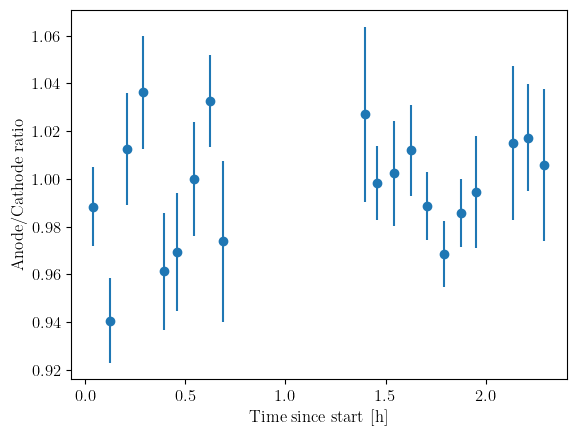

In [ ]:
## Now fit the rebinned data to get the outgassing rate

plt.figure()
plt.subplot(1,2,1)
plt.errorbar(ReconAmpFitRatio[:,0], ReconAmpFitRatio[:,1], yerr=ReconAmpFitRatio[:,2], fmt='o')

plt.xlabel('Time since start [h]')
plt.ylabel("Anode/Cathode ratio")